In [16]:
import pandas as pd
import numpy as np
import itertools

In [63]:
data = {
    'Alt': ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes'],
    'Bar': ['No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'Fri': ['No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'Hun': ['Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'Pat': ['Some', 'Full', 'Some', 'Full', 'Full', 'Some', 'None', 'Some', 'Full', 'Full', 'None', 'Full'],
    'Price': ['$$$', '$', '$', '$', '$$$', '$$', '$', '$$', '$', '$$$', '$', '$'],
    'Rain': ['No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No'],
    'Res': ['Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No'],
    'Type': ['French', 'Thai', 'Burger', 'Thai', 'French', 'Italian', 'Burger', 'Thai', 'Burger', 'Italian', 'Thai', 'Burger'],
    'Est': ['0-10', '30-60', '0-10', '10-30', '>60', '0-10', '0-10', '0-10', '>60', '10-30', '0-10', '30-60'],
    'WillWait': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes'],
}

df = pd.DataFrame(data=data)
df

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,WillWait
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,Yes,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [56]:
def entropy(y):
  '''
  Calculates the entropy. 
  '''
  a = y.value_counts()/y.shape[0]
  entropy = np.sum(-a*np.log2(a+1e-9))
  return(entropy)

In [57]:
def information_gain(y, mask, func=entropy):
  '''
  Calculate information gain of a variable given a loss function.
  '''
  
  a = sum(mask)
  b = mask.shape[0] - a
  
  if(a == 0 or b ==0): 
    ig = 0
  
  else:
      ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
  
  return ig

In [58]:
def categorical_options(a):
  '''
  Creates all possible combinations.
  '''
  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):
  '''
  Given a predictor & target variable, returns the best split.
  '''

  split_value = []
  ig = [] 

  numeric_variable = True if x.dtypes != 'O' else False

  # Create options according to variable type
  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else: 
    options = categorical_options(x)

  # Calculate ig for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_ig = information_gain(y, mask, func)
    # Append results
    ig.append(val_ig)
    split_value.append(val)

  # Check if there are more than 1 results if not, return False
  if len(ig) == 0:
    return(None,None,None, False)

  else:
  # Get results with highest IG
    best_ig = max(ig)
    best_ig_index = ig.index(best_ig)
    best_split = split_value[best_ig_index]
    return(best_ig,best_split,numeric_variable, True)

In [ ]:
def get_best_split(y, data):
  '''
  Given a data, select the best split and return the variable, the value and the information gain.
  '''
  masks = data.drop(y, axis= 1).apply(max_information_gain_split, y = data[y])
  masks.reset_index(inplace=True)
  masks.drop(["index"], axis=1, inplace=True)
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = max(masks)
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1] 
    split_ig = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_ig, split_numeric)

def make_split(variable, value, data, is_numeric):
  '''
  Given a data and a split conditions, do the split.
  '''
  if is_numeric:
    data_1 = data[data[variable] < value]
    data_2 = data[(data[variable] < value) == False]

  else:
    data_1 = data[data[variable].isin(value)]
    data_2 = data[(data[variable].isin(value)) == False]

  return(data_1,data_2)

def make_prediction(data, target_factor):
  '''
  Given the target variable, make a prediction.
  '''
  if target_factor:
    pred = data.value_counts().idxmax()
  else:
    pred = data.mean()

  return pred

In [86]:
def train_tree(data, y, target_factor, max_depth=None, min_samples_split=2, min_information_gain=1e-20, counter=0, max_categories=20):
  '''
  Trains a Decission Tree
  '''

  # Check that max_categories is fulfilled
  if counter==0:
    types = data.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(data[column].value_counts()) 
      if var_length > max_categories:
        raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  # Check for depth conditions
  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  # Check for sample conditions
  if min_samples_split == None:
    sample_cond = True

  else:
    if data.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  # Check for ig condition
  if depth_cond & sample_cond:

    var,val,ig,var_type = get_best_split(y, data)

    # If ig condition is fulfilled, make split 
    if ig is not None and ig >= min_information_gain:

      counter += 1

      left,right = make_split(var, val, data, var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val) 
      subtree = {question: []}


      # Find answers (recursion)
      yes_answer = train_tree(left, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)

      no_answer = train_tree(right, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    # If it doesn't match IG condition, make prediction
    else:
      pred = make_prediction(data[y],target_factor)
      return pred

   # Drop dataset if doesn't match depth or sample conditions
  else:
    pred = make_prediction(data[y],target_factor)
    return pred

  return subtree

In [87]:
decisions = train_tree(df, 'WillWait', True, max_depth=5)
decisions

{"Type in  ['Thai']": [{"Res in  ['Yes']": ['Yes',
    {"Rain in  ['No']": ['No', 'Yes']}]},
  'Yes']}

In [88]:
def classify(observation, arbol):
  question = list(arbol.keys())[0] 

  if question.split()[1] == '<=':

    if observation[question.split()[0]] <= float(question.split()[2]):
      answer = arbol[question][0]
    else:
      answer = arbol[question][1]

  else:

    if observation[question.split()[0]] in (question.split()[2]):
      answer = arbol[question][0]
    else:
      answer = arbol[question][1]

  # If the answer is not a dictionary
  if not isinstance(answer, dict):
    return answer
  else:
    residual_tree = answer
    return classify(observation, answer)

In [113]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = df.iloc[:, :-1].apply(lambda x: pd.factorize(x)[0])
y = df.iloc[:, -1].replace({'Yes':1, 'No':0})
clf = clf.fit(X, y)

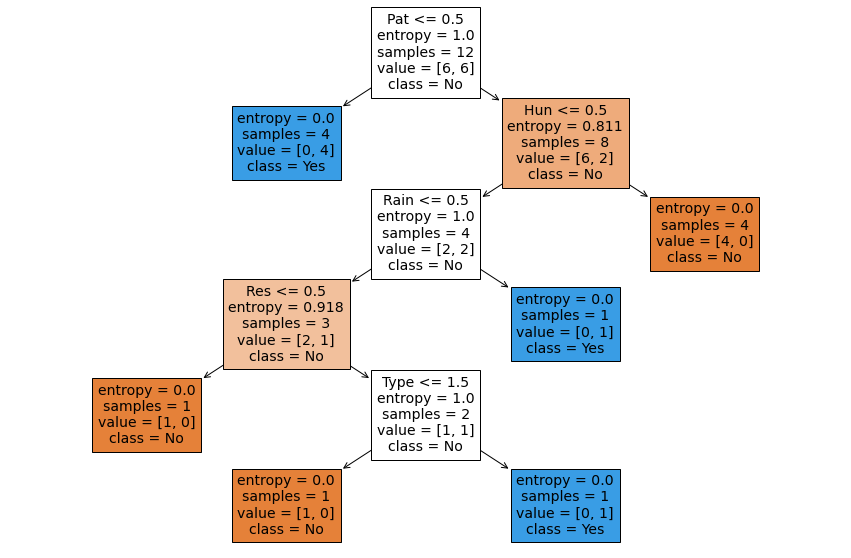

In [134]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(15,10))
tree.plot_tree(clf, feature_names=df.columns[:-1],  class_names=['No', 'Yes'], filled=True)

plt.show()